# Using Pretrained word 2 Vec

In [35]:
import os
import spacy
from tqdm import tqdm
import pandas as pd
import numpy as np
import ast
import plotly.express as px
from sklearn.manifold import TSNE
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow import keras
import transformers 
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from transformers import TFAutoModel, AutoTokenizer
from transformers import AutoConfig
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
tqdm.pandas()

In [2]:
embedding_path = r"C:\Holmusk\analysis"

In [3]:
def load_embedding(file_name = "bert_embedding.csv"):
    emb = pd.read_csv(os.path.join(embedding_path,file_name))
    emb.drop(['Unnamed: 0'], axis=1, inplace=True)
    return emb

In [4]:
# Load the sapcy model
nlp_sm = spacy.load("en_core_web_sm")

In [5]:
nlp_lg = spacy.load("en_core_web_lg")

In [4]:
#data = pd.read_csv("C:\Holmusk\MedicalNotesNLPChallenge\cleaned_chunked_clinic_notes.csv")
data = pd.read_csv("C:\Holmusk\MedicalNotesNLPChallenge\ClinNotes.csv")

In [5]:
medical_terms = pd.read_csv("C:\Holmusk\MedicalNotesNLPChallenge\MedicalConcepts.csv")
medical_terms['Term1'] = medical_terms['Term1'].apply(lambda x: x.lower())
medical_terms['Term2'] = medical_terms['Term2'].apply(lambda x: x.lower())
medical_terms.drop_duplicates(keep='first', inplace=True)
medical_terms.shape

(558, 2)

In [6]:
def calculate_similarity(row):
    similarity = cosine_similarity([row['term1']], [row['term2']])[0][0]
    return similarity

In [7]:
def getEmbedding(row, nlp):
    doc = nlp(row)
    embedding = doc.vector
    return embedding

In [8]:
def plotKmeansClusteredEmbeddings(embeddings, model):
    kmeans = KMeans(n_clusters=3)
    cluster_labels = kmeans.fit_predict(embeddings)

    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)
    plt.figure(figsize=(12, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f'K-means Clustering of {model} Embeddings')
    plt.show()

In [89]:
def plotEmbeddings(embeddings, categories, model):
    df = pd.DataFrame(embeddings)
    df["Data_Point"] = categories
    
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(df.drop(["Data_Point"], axis=1))

    df["TSNE_X"] = embeddings_tsne[:, 0]
    df["TSNE_Y"] = embeddings_tsne[:, 1]

    fig = px.scatter(df, x="TSNE_X", y="TSNE_Y", hover_data={"Data_Point": True}, color="Data_Point",
                     title=f"Embeddings Visualization with {model} Embedding size: {len(embeddings[0])}")

    fig.update_traces(hovertemplate="Data Point: %{customdata[0]}")

    fig.update_layout(legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5))

    fig.show()
    fig.write_html(f"{model}_{len(embeddings[0])}.html")

# get embedding from pretrained word2vec from smaller spacy model

In [28]:
res_sm = data['notes'].apply(getEmbedding, args=(nlp_sm,))

In [29]:
pd.DataFrame(list(res_sm)).to_csv(os.path.join(embedding_path,'row_word2vec_96_embedding.csv'))

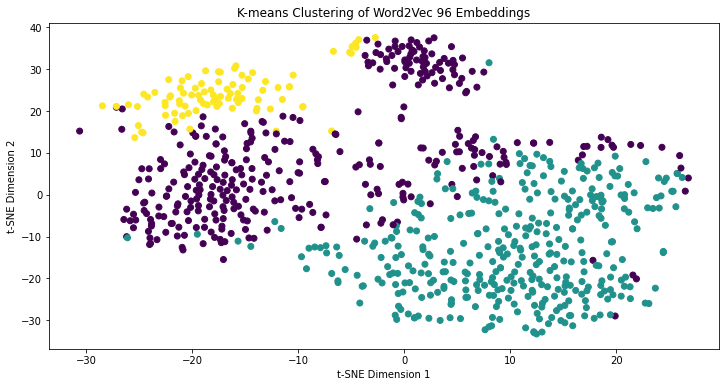

In [31]:
res_sm = np.array(load_embedding(file_name = "row_word2vec_96_embedding.csv"))
plotKmeansClusteredEmbeddings(list(res_sm), 'Word2Vec 96')

<b> Note that above approach to verify embedding quality is not good for the kind of data that we are dealing with</b>

# Lets verify embedding quality by getting embedding for clinic notes data and then plotting it against category Neurology ,cardiovascular and Gastro

In [95]:
res_sm = np.array(load_embedding(file_name = "row_word2vec_96_embedding.csv"))
plotEmbeddings(list(res_sm), data['category'].values, 'word2vec')

# get embedding for medical keywords and calculate similarity using word2vec_sm

In [15]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(getEmbedding, args=(nlp_sm,))
res2 = medical_terms["Term2"][:top].apply(getEmbedding, args=(nlp_sm,))
res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

w2v_sm = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   239.9576534051448
mean cosine_similarity =   0.43003153800964355


# get embedding from pretrained word2vec from larger spacy model

In [34]:
res_lg = data['notes'].apply(getEmbedding, args=(nlp_lg,))

In [44]:
pd.DataFrame(list(res_lg)).to_csv(os.path.join(embedding_path,'raw_word2vec_300_embedding.csv'))

In [45]:
res_lg = np.array(load_embedding(file_name = "raw_word2vec_300_embedding.csv"))
plotEmbeddings(list(res_lg), data['category'].values, 'word2vec')

# get embedding for medical keywords and calculate similarity using word2vec_lg

In [17]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(getEmbedding, args=(nlp_lg,))
res2 = medical_terms["Term2"][:top].apply(getEmbedding, args=(nlp_lg,))
res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)
w2v_lg = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   128.0270563007798
mean cosine_similarity =   0.22943921387195587


# Using Elmo to get Embedding

In [5]:
# Load the pre-trained ELMo model
elmo = hub.load("https://tfhub.dev/google/elmo/3")

In [21]:
def get_elmo_embedding(sentences):
    embeddings = elmo.signatures["default"](tf.constant([sentences]))["elmo"]
    sentence_embeddings = tf.reduce_mean(embeddings, axis=1)
    return sentence_embeddings.numpy()[0]

In [22]:
res_elmo = data['notes'].apply(get_elmo_embedding)

In [ ]:
pd.DataFrame(list(res_elmo)).to_csv(os.path.join(embedding_path,'raw_elmo_pretrained_embeddings.csv'))

In [33]:
res_elmo = np.array(load_embedding(file_name = "raw_elmo_pretrained_embeddings.csv"))
plotEmbeddings(list(res_elmo), data['category'].values, 'Elmo')

In [34]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_elmo_embedding)
res2 = medical_terms["Term2"][:top].apply(get_elmo_embedding)

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)
print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   308.23337239027023
mean cosine_similarity =   0.5523895


# Using BERT to Get Embedding

In [13]:
def get_bert_embedding(sentence, model, tokenizer):

    tokens = tokenizer.encode_plus(sentence, padding=True, truncation=True, max_length=512, return_tensors="tf")

    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    outputs = model(input_ids, attention_mask=attention_mask)

    hidden_states = outputs.last_hidden_state

    mask = tf.cast(tf.expand_dims(attention_mask, axis=-1), tf.float32)

    masked_hidden_states = hidden_states * mask

    sentence_representations = tf.reduce_sum(masked_hidden_states, axis=1) / tf.reduce_sum(mask, axis=1)
    return sentence_representations

# Bert Base Uncased

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

res_bert = data['notes'].apply(get_bert_embedding, args=(model,tokenizer))

In [40]:
res_bert1 = [res[0].numpy() for res in res_bert]
pd.DataFrame(res_bert1).to_csv(os.path.join(embedding_path,'raw_bert_embedding.csv'))

In [41]:
res_bert1 = np.array(load_embedding(file_name = "raw_bert_embedding.csv"))
plotEmbeddings(list(res_bert1), data['category'].values, 'BERT')

# get embedding for medical keywords and calculate similarity using BERT base

In [22]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding)
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding)

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   319.710486933589
mean cosine_similarity =   0.57295823097229


# Using BioBERT to Get Embedding. This model is trained on bio medical data

In [ ]:
bio_model_name = "dmis-lab/biobert-v1.1"
bio_tokenizer = AutoTokenizer.from_pretrained(bio_model_name)
bio_model = TFAutoModel.from_pretrained(bio_model_name, from_pt=True)

res_bio_bert = data['notes'].apply(get_bert_embedding, args=(bio_model,bio_tokenizer))

In [49]:
res_bio_bert1 = [res[0].numpy() for res in res_bio_bert]
pd.DataFrame(res_bio_bert1).to_csv(os.path.join(embedding_path,'raw_bio_bert_embedding.csv'))

In [50]:
res_bio_bert1 = np.array(load_embedding(file_name = "raw_bio_bert_embedding.csv"))
plotEmbeddings(list(res_bio_bert1), data['category'].values, 'BioBERT')

# get embedding for medical keywords and calculate similarity using BioBert

In [26]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(bio_model,bio_tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(bio_model,bio_tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

bio_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   447.63191509246826
mean cosine_similarity =   0.8022072911262512


# Using ClinicalBert to get Embeddings. This model is trained on clinical notes

In [54]:
clinic_model_name = "emilyalsentzer/Bio_ClinicalBERT"
clinic_tokenizer = AutoTokenizer.from_pretrained(clinic_model_name)
clinic_model = TFAutoModel.from_pretrained(clinic_model_name)

res_clinic_bert = data['notes'].apply(get_bert_embedding, args=(clinic_model, clinic_tokenizer))

In [55]:
res_clinic_bert1 = [res[0].numpy() for res in res_clinic_bert]
pd.DataFrame(res_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_clinic_bert_embedding.csv'))

In [94]:
res_clinic_bert1 = np.array(load_embedding(file_name = "raw_clinic_bert_embedding.csv"))
plotEmbeddings(list(res_clinic_bert1), data['category'].values, 'ClinicalBERT')

# get embedding for medical keywords and calculate similarity using ClincalBERT

In [24]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(clinic_model, clinic_tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(clinic_model, clinic_tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

clinical_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   453.973201751709
mean cosine_similarity =   0.8135718107223511


# Using BlueBert to get Embeddings. This model is trained on clinical notes

In [59]:
blue_model_name = "bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12"
blue_tokenizer = AutoTokenizer.from_pretrained(blue_model_name)
blue_model = TFAutoModel.from_pretrained(blue_model_name, from_pt=True)

res_blue_bert = data['notes'].apply(get_bert_embedding, args=(blue_model,blue_tokenizer))

In [60]:
res_blue_bert1 = [res[0].numpy() for res in res_blue_bert]
pd.DataFrame(res_blue_bert1).to_csv(os.path.join(embedding_path,'raw_blue_bert_embedding.csv'))

In [93]:
res_blue_bert1 = np.array(load_embedding(file_name = "raw_blue_bert_embedding.csv"))
plotEmbeddings(list(res_blue_bert1), data['category'].values, 'BlueBERT')

# get embedding for medical keywords and calculate similarity using BlueBERT

In [53]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(blue_model,blue_tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(blue_model,blue_tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

blue_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   404.4722881615162
mean cosine_similarity =   0.7248604893684387


# Checking All Models perfoemce together on cosine similarity task

In [ ]:
chars = ['word2vec_small', 'word2vec_large', 'bert', 'bio_bert', 'clinical_bert', 'blue_bert']
numbers = [round(np.mean(w2v_sm) * 100, 2), round(np.mean(w2v_lg) * 100, 2), round(np.mean(bert) * 100, 2),
           round(np.mean(bio_bert) * 100, 2), round(np.mean(clinical_bert) * 100, 2), round(np.mean(blue_bert) * 100, 2)]


pd.DataFrame({"chart": chars, "similarity_score" : numbers}).to_csv("similarity_score.csv")

In [17]:
similarity_score = pd.read_csv("similarity_score.csv")

chars = list(similarity_score['chart'])
numbers = list(similarity_score['similarity_score'])

In [70]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Bar(x=chars, y=numbers, text=numbers, textposition='auto', hoverinfo='none'))

fig.update_layout(xaxis_title='Models', yaxis_title='Cosine Similarity (%)', title='Model vs Cosine Similarity on Medical Keyword Pairs')

fig.show()


# Lets Now Fine tune ClinicalBERT model further as it is the Best Model So far

<li>Code for fine tunning the models and preprocessing the data exists in other ipynb files
<li>Please refer preprocessing_data.ipynb fine to check preprocessing steps that i perfoemd.
<li>Please check model_tunning.ipynb fine to check model configuartion and architecture infromation
<li>I have uploaded all files on my gihub. link is below-

In [10]:
def get_embedding_from_finetuned_bert(sentence, tuned_model, tokenizer):
    
    max_len = 512
    tokens = tokenizer(sentence, truncation=True, padding=True, max_length=max_len, return_tensors="tf")
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    
    
    outputs = tuned_model([input_ids,attention_mask])
    
    hidden_states = outputs['last_hidden_state']

    mask = tf.cast(tf.expand_dims(attention_mask, axis=-1), tf.float32)

    masked_hidden_states = hidden_states * mask

    sentence_representations = tf.reduce_sum(masked_hidden_states, axis=1) / tf.reduce_sum(mask, axis=1)
    return sentence_representations

# Finetuned model on clinical notes

In [12]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [13]:
tuned_model = keras.models.load_model(r'C:\Holmusk\model\clinical_bert_fine_tuned_for_notes.h5', 
                                 custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
tuned_clinic_bert = data['notes'].apply(get_embedding_from_finetuned_bert, args=(tuned_model, tokenizer))
tuned_clinic_bert1 = [res[0].numpy() for res in tuned_clinic_bert]
pd.DataFrame(tuned_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_tuned_clinic_notes_bert_embedding_new.csv'))

In [92]:
tuned_clinic_bert1 = np.array(load_embedding(file_name = "raw_tuned_clinic_notes_bert_embedding_new.csv"))
plotEmbeddings(list(tuned_clinic_bert1), data['category'].values, 'finetuned model on clinical notes')

# get embedding for medical keywords and calculate similarity using notes_based_tuned_clinical_bert

In [14]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_embedding_from_finetuned_bert, args=(tuned_model, tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_embedding_from_finetuned_bert, args=(tuned_model, tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

finetuned_clinical_bert = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   433.7339897155762
mean cosine_similarity =   0.7773011922836304


# keyword pair based finetuned model 

In [10]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
keyword_tuned_model = keras.models.load_model(r'C:\Holmusk\model\clinical_bert_fine_tuned_for_medic_keywords.h5', 
                                 custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
keyword_tuned_clinic_bert = data['notes'].apply(get_embedding_from_finetuned_bert, args=(keyword_tuned_model, tokenizer))
keyword_tuned_clinic_bert1 = [res[0].numpy() for res in keyword_tuned_clinic_bert]
pd.DataFrame(tuned_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_keyword_tuned_bert_embedding_new.csv'))

In [91]:
tuned_clinic_bert1 = np.array(load_embedding(file_name = "raw_keyword_tuned_bert_embedding_new.csv"))
plotEmbeddings(list(tuned_clinic_bert1), data['category'].values, 'keyword pair based finetuned model')

# get embedding for medical keywords and calculate similarity using keyword_based_tuned_clinical_bert

In [31]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_embedding_from_finetuned_bert, args=(keyword_tuned_model, tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_embedding_from_finetuned_bert, args=(keyword_tuned_model, tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

finetuned_clinical_bert_for_keywords = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   456.11888909339905
mean cosine_similarity =   0.8174178600311279


# Model trained on clinical notes and keyword pair both

In [ ]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
bert_model.load_weights("C:\Holmusk\model\clinic_noes_and_keyword_based_trained_model.h5")

In [ ]:
keyword_clinic_tuned_clinic_bert = data['notes'].apply(get_bert_embedding, args=(bert_model, tokenizer))
keyword_clinic_tuned_clinic_bert1 = [res[0].numpy() for res in keyword_clinic_tuned_clinic_bert]
pd.DataFrame(keyword_clinic_tuned_clinic_bert1).to_csv(os.path.join(embedding_path,'raw_clinc_keyword_tuned_bert_embedding.csv'))

In [90]:
keyword_clinic_tuned_clinic_bert1 = np.array(load_embedding(file_name = "raw_clinc_keyword_tuned_bert_embedding.csv"))
plotEmbeddings(list(keyword_clinic_tuned_clinic_bert1), data['category'].values, 'Model trained on clinical notes and keyword pair both')

In [42]:
top = len(medical_terms)
res1 = medical_terms["Term1"][:top].apply(get_bert_embedding, args=(bert_model,tokenizer))
res2 = medical_terms["Term2"][:top].apply(get_bert_embedding, args=(bert_model,tokenizer))

res1 = [res[0].numpy() for res in res1]
res2 = [res[0].numpy() for res in res2]

res = pd.DataFrame({'term1':res1, 'term2': res2}).apply(calculate_similarity, axis=1)

finetuned_clinical_bert_for_keywords_and_notes = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   436.2237065434456
mean cosine_similarity =   0.78176296


# Lets see all model's performence once again on similarity task

In [ ]:

chars = ['word2vec_small', 'word2vec_large', 'bert', 'bio_bert', 'clinical_bert', 'blue_bert','clinic_notes_based_finetuned_bert',
         "keyword_based_finetuned_bert", "keyword_and_clinic_notes_based_finetuned_bert1"]
numbers = [round(np.mean(w2v_sm) * 100, 2), round(np.mean(w2v_lg) * 100, 2), round(np.mean(bert) * 100, 2),
           round(np.mean(bio_bert) * 100, 2), round(np.mean(clinical_bert) * 100, 2), round(np.mean(blue_bert) * 100, 2),
          round(np.mean(finetuned_clinical_bert) * 100, 2), round(np.mean(finetuned_clinical_bert_for_keywords) * 100, 2),
          round(np.mean(finetuned_clinical_bert_for_keywords_and_notes) * 100, 2)]

In [99]:
pd.DataFrame({"chart": chars, "similarity_score" : numbers}).to_csv("all_model_similarity.csv")

In [100]:
similarity_score = pd.read_csv("all_model_similarity.csv")

chars = list(similarity_score['chart'])
numbers = list(similarity_score['similarity_score'])

In [101]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Bar(x=chars, y=numbers, text=numbers, textposition='auto', hoverinfo='none'))

fig.update_layout(xaxis_title='Models', yaxis_title='Cosine Similarity (%)', title='Model vs Cosine Similarity on Medical Keyword Pairs')

fig.show()


In [97]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Bar(x=chars[-3:], y=numbers[-3:], text=numbers[-3:], textposition='auto', hoverinfo='none'))

fig.update_layout(xaxis_title='Models', yaxis_title='Cosine Similarity (%)', title='Model vs Cosine Similarity on Medical Keyword Pairs')

fig.show()